# Global E-Commerce Analytics  (API + SQL + Python )

Built a Python-based system to fetch live e-commerce product and currency exchange data from APIs, store it in a SQL database, and import it into Excel for analysis and visualization using Python.

🔗 APIs Used

🛍️ FakeStore API — https://fakestoreapi.com/products

(Real-time product data)

💱 ExchangeRate API — https://api.exchangerate-api.com/v4/latest/USD

(Real-time currency conversion)

# Fetch the Live Data

In [1]:

import requests
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

# --- Fetch product data ---
products_url = "https://fakestoreapi.com/products"
products = requests.get(products_url).json()
df = pd.DataFrame(products)

# --- Fetch currency data ---
currency_url = "https://api.exchangerate-api.com/v4/latest/USD"
rates = requests.get(currency_url).json()['rates']

print("✅ Data fetched successfully")



✅ Data fetched successfully


# Clean Transform the Data

In [2]:
# Extract ratings
df['rate'] =df['rating'].apply(lambda x: x['rate'])
df['count']=df['rating'].apply(lambda x: x['count'])
df.drop('rating',axis=1,inplace=True)     





In [3]:
# Select relevent columns
df = df[['id', 'title', 'price', 'category', 'rate','count']]

# Add price conversions
df['price_in_inr'] = df['price'] * rates['INR']
df['price_in_eur'] = df['price'] * rates['EUR']

# Add simulated sales
import numpy as np
df['monthly_sales'] = np.random.randint(50, 500, df.shape[0])

print(df.head())



   id                                              title   price  \
0   1  Fjallraven - Foldsack No. 1 Backpack, Fits 15 ...  109.95   
1   2             Mens Casual Premium Slim Fit T-Shirts    22.30   
2   3                                 Mens Cotton Jacket   55.99   
3   4                               Mens Casual Slim Fit   15.99   
4   5  John Hardy Women's Legends Naga Gold & Silver ...  695.00   

         category  rate  count  price_in_inr  price_in_eur  monthly_sales  
0  men's clothing   3.9    120     9758.0625       94.5570            298  
1  men's clothing   4.1    259     1979.1250       19.1780            180  
2  men's clothing   4.7    500     4969.1125       48.1514            319  
3  men's clothing   2.1    430     1419.1125       13.7514            229  
4        jewelery   4.6    400    61681.2500      597.7000            368  


# Store the Data in SQL Database ( MySQL)

In [4]:
conn = sqlite3.connect('ecommerce_data.db')
df.to_sql('products', conn, if_exists='replace', index=False)
print("✅ Data inserted into SQLite database successfully!")


✅ Data inserted into SQLite database successfully!


# Using MySQL (for production or cloud-based setup)

In [5]:
import mysql.connector

# Connect without specifying a database
mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  password="root"  # use your MySQL password
)
cursor = mydb.cursor()

# Create the database
cursor.execute("CREATE DATABASE IF NOT EXISTS ecommerce;")
print("✅ Database 'ecommerce' created successfully!")

mydb.close()


✅ Database 'ecommerce' created successfully!


In [6]:
mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  password="root",
  database="ecommerce"
)
cursor = mydb.cursor()
print("✅ Connected to 'ecommerce' database successfully!")

✅ Connected to 'ecommerce' database successfully!


In [7]:
cursor = mydb.cursor()

# Create table
cursor.execute("""
CREATE TABLE IF NOT EXISTS products (
  id INT PRIMARY KEY,
  title TEXT,
  price FLOAT,
  category TEXT,
  rate FLOAT,
  count INT,
  price_in_inr FLOAT,
  price_in_eur FLOAT,
  monthly_sales INT
)
""")

# Insert records
for _, row in df.iterrows():
    cursor.execute("""
    INSERT INTO products VALUES (%s,%s,%s,%s,%s,%s,%s,%s,%s)
    """, tuple(row))
mydb.commit()
print("✅ Data inserted into MySQL successfully!")

IntegrityError: 1062 (23000): Duplicate entry '1' for key 'products.PRIMARY'

# Perform SQL Analysis And Visualization

           category  avg_price
0       electronics     332.50
1          jewelery     221.00
2    men's clothing      51.06
3  women's clothing      26.29


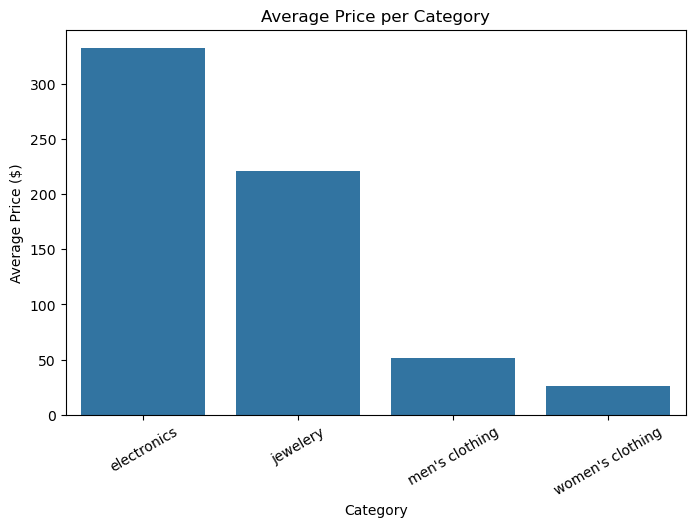

In [8]:
# Average Price per Category
query = "SELECT category, ROUND(AVG(price),2) AS avg_price FROM products GROUP BY category;"
avg_price = pd.read_sql_query(query, conn)
print(avg_price)

plt.figure(figsize=(8,5))
sns.barplot(x='category', y='avg_price', data=avg_price)
plt.title("Average Price per Category")
plt.xlabel("Category")
plt.ylabel("Average Price ($)")
plt.xticks(rotation=30)
plt.show()


                                               title  rate   price
0  Silicon Power 256GB SSD 3D NAND A55 SLC Cache ...   4.8  109.00
1  WD 4TB Gaming Drive Works with Playstation 4 P...   4.8  114.00
2                                 Mens Cotton Jacket   4.7   55.99
3        MBJ Women's Solid Short Sleeve Boat Neck V    4.7    9.85
4  John Hardy Women's Legends Naga Gold & Silver ...   4.6  695.00


C:\Users\HP\AppData\Local\Temp\ipykernel_27976\2057089699.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='rate', y='title', data=top_products, palette="viridis")


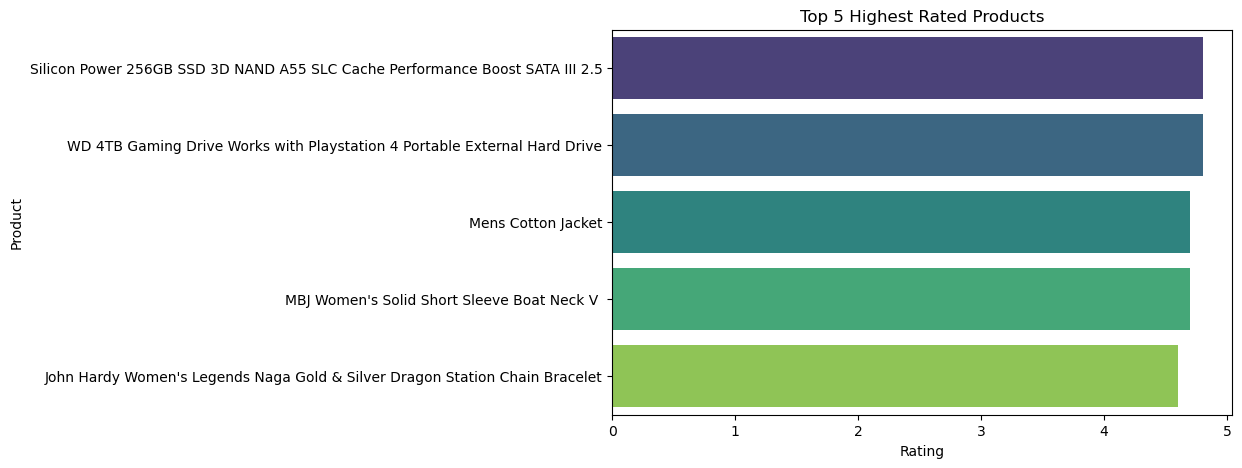

In [9]:
# Top  5 highest Rated Products
query = "SELECT title, rate, price FROM products ORDER BY rate DESC LIMIT 5;"
top_products = pd.read_sql_query(query, conn)
print(top_products)

plt.figure(figsize=(8,5))
sns.barplot(x='rate', y='title', data=top_products, palette="viridis")
plt.title("Top 5 Highest Rated Products")
plt.xlabel("Rating")
plt.ylabel("Product")
plt.show()

In [ ]:
# Most Sold Categories
query = "SELECT category, SUM(monthly_sales) AS total_sales FROM products GROUP BY category ORDER BY total_sales DESC;"
category_sales = pd.read_sql_query(query, conn)
print(category_sales)

plt.figure(figsize=(8,5))
sns.barplot(x='category', y='total_sales', data=category_sales, palette="magma")
plt.title("Most Sold Categories")
plt.xlabel("Category")
plt.ylabel("Total Sales")
plt.xticks(rotation=30)
plt.show()


In [ ]:
#  Price Comparison Across Currencies
# Correct Query — No CONCAT (numeric values for plotting)
query = """
SELECT 
    title,  
    category,  
    ROUND(price, 2) AS price_usd,  
    ROUND(price_in_inr, 2) AS price_inr,  
    ROUND(price_in_eur, 2) AS price_eur
FROM products
ORDER BY price DESC
LIMIT 10;
"""

# Fetch data
price_comparison = pd.read_sql_query(query, conn)
print(price_comparison)

plt.figure(figsize=(12,6))
plt.plot(price_comparison['title'], price_comparison['price_usd'], marker='o', label='USD ($)')
plt.plot(price_comparison['title'], price_comparison['price_inr'], marker='o', label='INR (₹)')
plt.plot(price_comparison['title'], price_comparison['price_eur'], marker='o', label='EUR (€)')
plt.xticks(rotation=45, ha='right')
plt.title("Price Comparison Across Currencies (Top 10 Products)")
plt.xlabel("Product Title")
plt.ylabel("Price Value")
plt.legend()
plt.tight_layout()
plt.show()



In [ ]:
# Category with Highest Average Rating but Lowest Price
query = """
SELECT 
    category,
    ROUND(AVG(rate), 2) AS avg_rating,
    ROUND(AVG(price), 2) AS avg_price
FROM products
GROUP BY category
ORDER BY avg_rating DESC, avg_price ASC
LIMIT 1;


"""
Highest_Average_Rating_but_Lowest_Price = pd.read_sql_query(query, conn)
print(Highest_Average_Rating_but_Lowest_Price)

plt.figure(figsize=(8,5))
sns.scatterplot(x='avg_price', y='avg_rating', data=Highest_Average_Rating_but_Lowest_Price, hue='category', s=100)
plt.title("Categories with High Rating and Low Price")
plt.xlabel("Average Price ($)")
plt.ylabel("Average Rating")
plt.show()


In [ ]:
# Category Contribution to Total Revenue
query = """
SELECT 
    category,
    ROUND(SUM(price * monthly_sales), 2) AS category_revenue,
    ROUND((SUM(price * monthly_sales) * 100 / (SELECT SUM(price * monthly_sales) FROM products)), 2) AS percentage_contribution
FROM products
GROUP BY category
ORDER BY category_revenue DESC;

"""
Category_Contribution_to_Total_Revenue = pd.read_sql_query(query, conn)
print(Category_Contribution_to_Total_Revenue)

plt.figure(figsize=(6,6))
plt.pie(Category_Contribution_to_Total_Revenue['percentage_contribution'], labels=Category_Contribution_to_Total_Revenue['category'], autopct='%1.1f%%', startangle=90)
plt.title("Category Contribution to Total Revenue")
plt.show()


# Export to Excel

In [ ]:
df.to_excel("global_ecommerce_data.xlsx", index=False)
print("✅ Data exported in Excel!")
